In [1]:
# Train on RAF-DB
import torch
print("CUDA available:", torch.cuda.is_available())
print("Device count:", torch.cuda.device_count())
print("Current device:", torch.cuda.current_device())
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")
torch.cuda.empty_cache()


CUDA available: True
Device count: 1
Current device: 0
Device name: NVIDIA GeForce RTX 3070


In [2]:
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm

from torch.utils.data import DataLoader
from torchvision import transforms
import torch.optim as optim
import matplotlib.pyplot as plt

from approach.resnet import ResNet34, ResNet18
from approach.vgg import VGG

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

# Transform the dataset
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])
# Load the model

model_resnet18 = ResNet18().to(device)
model_resnet34 = ResNet34().to(device)
model_vgg= VGG().to(device)
models = [model_resnet18, model_resnet34, model_vgg]
# models_names = ["resnet18_raf-db_1", "resnet34_raf-db_1", "vgg_raf-db_1"]
models_names = ["resnet18_fer2013_1", "resnet34_fer2013_1", "vgg_fer2013_1"]

Using cuda device


In [3]:
import os
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

def load_data(base_dir, batch_size=16, transform=None):
    """
    Function to load train and test datasets and return their DataLoaders.

    Args:
        base_dir (str): Base directory containing train/test subdirectories.
        batch_size (int): Batch size for the DataLoader.
        transform (callable, optional): Transformations to apply to the images.

    Returns:
        tuple: Train DataLoader, Validation DataLoader
    """
    # Define train and test directories
    train_dir = os.path.join(base_dir, "train")
    val_dir = os.path.join(base_dir, "test")
    
    # Use torchvision.datasets.ImageFolder to automatically handle class folders
    train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
    test_dataset = datasets.ImageFolder(root=val_dir, transform=transform)
    
    label_names = train_dataset.classes

    # Split train_dataset into training and validation sets
    val_size = 3500
    train_size = len(train_dataset) - val_size
    train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

    # DataLoaders
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    

    # Print dataset sizes
    print(f"Number of images in train loader: {len(train_loader.dataset)}")
    print(f"Number of images in val loader: {len(val_loader.dataset)}")
    print(f"Number of images in test loader: {len(test_loader.dataset)}")

    return train_loader, test_loader, val_loader, label_names


# Load data
base_dir = "/workspace/fer2013"
train_loader, test_loader, val_loader, label_names = load_data(base_dir=base_dir, batch_size=16, transform=transform)

# Inspect a batch
train_images, train_labels = next(iter(train_loader))
print(f"Train batch: Images shape {train_images.shape}, Labels shape {train_labels.shape}")

test_images, test_labels = next(iter(test_loader))
print(f"Train batch: Images shape {test_images.shape}, Labels shape {test_labels.shape}")


Number of images in train loader: 25321
Number of images in val loader: 3500
Number of images in test loader: 7066
Train batch: Images shape torch.Size([16, 3, 64, 64]), Labels shape torch.Size([16])
Train batch: Images shape torch.Size([16, 3, 64, 64]), Labels shape torch.Size([16])


In [4]:
import h5py

def save_csv(epoch_counter, train_losses, test_losses, val_losses, train_accuracies, test_accuracies, val_accuracies, model_name):
    # Truncate the lists to match the number of epochs
    train_losses = train_losses[:epoch_counter]
    test_losses = test_losses[:epoch_counter]
    val_losses = val_losses[:epoch_counter]
    train_accuracies = train_accuracies[:epoch_counter]
    test_accuracies = test_accuracies[:epoch_counter]
    val_accuracies = val_accuracies[:epoch_counter]

    # Create the DataFrame
    df = pd.DataFrame({
        'Epoch': range(1, epoch_counter + 1),
        'Train Loss': train_losses,
        'Test Loss': test_losses,
        'Validation Loss': val_losses,
        'Train Accuracy': train_accuracies,
        'Test Accuracy': test_accuracies,
        'Validation Accuracy': val_accuracies
    })

    # Save the DataFrame to a CSV file
    csv_filename = f'result_{model_name}.csv'
    df.to_csv(csv_filename, index=False)

def save_model_as_h5(model, model_name):
    """
    Save a PyTorch model as an H5 file.

    Args:
        model (torch.nn.Module): The PyTorch model to save.
        file_path (str): Path to save the .h5 file.
    """
    # Convert the model's state_dict to a dictionary of NumPy arrays
    model_weights = {k: v.cpu().numpy() for k, v in model.state_dict().items()}
    file_path = f"model_{model_name}.h5"
    with h5py.File(file_path, 'w') as h5_file:
        for key, value in model_weights.items():
            h5_file.create_dataset(key, data=value)


In [5]:
# Start training
for model in models:
    # Hyperparameters
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

    patience = 15
    best_val_acc = 0
    patience_counter = 0
    epoch_counter = 0

    num_epochs = 80

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    test_losses = []
    test_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for data in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        model.eval()
        test_running_loss = 0.0
        test_correct = 0
        test_total = 0
        with torch.no_grad():
            for data in test_loader:
                inputs, labels = data[0].to(device), data[1].to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()

        test_loss = test_running_loss / len(test_loader)
        test_acc = test_correct / test_total
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for data in val_loader:
                inputs, labels = data[0].to(device), data[1].to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(val_loader)
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Train Accuracy: {train_acc}, Test Loss: {test_loss}, Test Accuracy: {test_acc}, Val Loss: {val_loss}, Val Accuracy: {val_acc}")
        epoch_counter += 1
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0 
            torch.save(model.state_dict(), f'best_model_{models_names[models.index(model)]}.pth')
        else:
            patience_counter += 1
            print(f"No improvement in validation accuracy for {patience_counter} epochs.")
        
        if patience_counter > patience:
            print("Stopping early due to lack of improvement in validation accuracy.")
            break
    save_csv(epoch_counter, train_losses, test_losses, val_losses, train_accuracies, test_accuracies, val_accuracies, models_names[models.index(model)])
    save_model_as_h5(model, models_names[models.index(model)])
    print("Model saved .h5")

Epoch 1/80: 100% 1583/1583 [00:38<00:00, 41.12it/s]


Epoch 1, Train Loss: 1.6106594418771494, Train Accuracy: 0.36254492318628806, Test Loss: 1.468088342121284, Test Accuracy: 0.4298046985564676, Val Loss: 1.468005168111357, Val Accuracy: 0.43685714285714283


Epoch 2/80: 100% 1583/1583 [00:34<00:00, 46.04it/s]


Epoch 2, Train Loss: 1.3523774515656226, Train Accuracy: 0.48161604991903956, Test Loss: 1.26769507676363, Test Accuracy: 0.5193886215680724, Val Loss: 1.2821493366537573, Val Accuracy: 0.5037142857142857


Epoch 3/80: 100% 1583/1583 [00:34<00:00, 46.25it/s]


Epoch 3, Train Loss: 1.2190707255900848, Train Accuracy: 0.5351684372655109, Test Loss: 1.2133526815885332, Test Accuracy: 0.5404755165581658, Val Loss: 1.2180320722599551, Val Accuracy: 0.5425714285714286


Epoch 4/80: 100% 1583/1583 [00:34<00:00, 45.77it/s]


Epoch 4, Train Loss: 1.1181244649468385, Train Accuracy: 0.5782946961020496, Test Loss: 1.1733054462904575, Test Accuracy: 0.5594395697707331, Val Loss: 1.170461157141211, Val Accuracy: 0.5677142857142857


Epoch 5/80: 100% 1583/1583 [00:34<00:00, 45.52it/s]


Epoch 5, Train Loss: 1.027151723263464, Train Accuracy: 0.6119821492042179, Test Loss: 1.1887448647173282, Test Accuracy: 0.5658080951033116, Val Loss: 1.1962151653962592, Val Accuracy: 0.5554285714285714
No improvement in validation accuracy for 1 epochs.


Epoch 6/80: 100% 1583/1583 [00:34<00:00, 46.05it/s]


Epoch 6, Train Loss: 0.9498035849383264, Train Accuracy: 0.6449192369969591, Test Loss: 1.1718365638032218, Test Accuracy: 0.568355505236343, Val Loss: 1.1879435708261517, Val Accuracy: 0.5631428571428572
No improvement in validation accuracy for 2 epochs.


Epoch 7/80: 100% 1583/1583 [00:34<00:00, 46.31it/s]


Epoch 7, Train Loss: 0.858010628576604, Train Accuracy: 0.6863473006595316, Test Loss: 1.1784085527450117, Test Accuracy: 0.5830738748938579, Val Loss: 1.199500954722705, Val Accuracy: 0.5774285714285714


Epoch 8/80: 100% 1583/1583 [00:34<00:00, 46.30it/s]


Epoch 8, Train Loss: 0.7824700405457617, Train Accuracy: 0.7167963350578571, Test Loss: 1.2658522550471767, Test Accuracy: 0.5667987545994905, Val Loss: 1.2651581240299086, Val Accuracy: 0.5714285714285714
No improvement in validation accuracy for 1 epochs.


Epoch 9/80: 100% 1583/1583 [00:35<00:00, 44.13it/s]


Epoch 9, Train Loss: 0.7026256570146571, Train Accuracy: 0.7449942735279017, Test Loss: 1.2659560116134347, Test Accuracy: 0.5672233229549958, Val Loss: 1.3211421238505132, Val Accuracy: 0.5577142857142857
No improvement in validation accuracy for 2 epochs.


Epoch 10/80: 100% 1583/1583 [00:36<00:00, 43.31it/s]


Epoch 10, Train Loss: 0.6193047900197631, Train Accuracy: 0.777180996011216, Test Loss: 1.6332365760571277, Test Accuracy: 0.4968864987262949, Val Loss: 1.6406079310260406, Val Accuracy: 0.48628571428571427
No improvement in validation accuracy for 3 epochs.


Epoch 11/80: 100% 1583/1583 [00:35<00:00, 44.00it/s]


Epoch 11, Train Loss: 0.5424289829977238, Train Accuracy: 0.8082224240748785, Test Loss: 1.3252548543331781, Test Accuracy: 0.5868949900934051, Val Loss: 1.3845781905738186, Val Accuracy: 0.5734285714285714
No improvement in validation accuracy for 4 epochs.


Epoch 12/80: 100% 1583/1583 [00:35<00:00, 44.15it/s]


Epoch 12, Train Loss: 0.4828846017422363, Train Accuracy: 0.8292326527388334, Test Loss: 1.5314859957076037, Test Accuracy: 0.5564675912821965, Val Loss: 1.4758304220084186, Val Accuracy: 0.556
No improvement in validation accuracy for 5 epochs.


Epoch 13/80: 100% 1583/1583 [00:34<00:00, 45.49it/s]


Epoch 13, Train Loss: 0.4176811007647502, Train Accuracy: 0.8544686228821926, Test Loss: 1.4883768424745734, Test Accuracy: 0.5608547976224172, Val Loss: 1.5525211142078381, Val Accuracy: 0.5511428571428572
No improvement in validation accuracy for 6 epochs.


Epoch 14/80: 100% 1583/1583 [00:36<00:00, 42.95it/s]


Epoch 14, Train Loss: 0.3701656536350353, Train Accuracy: 0.8736621776391138, Test Loss: 1.6030609463404746, Test Accuracy: 0.5649589583923011, Val Loss: 1.5879283624969116, Val Accuracy: 0.5622857142857143
No improvement in validation accuracy for 7 epochs.


Epoch 15/80: 100% 1583/1583 [00:37<00:00, 41.91it/s]


Epoch 15, Train Loss: 0.32318514324512876, Train Accuracy: 0.8874057106749339, Test Loss: 1.6024815987677596, Test Accuracy: 0.574157939428248, Val Loss: 1.6450310341299397, Val Accuracy: 0.5694285714285714
No improvement in validation accuracy for 8 epochs.


Epoch 16/80: 100% 1583/1583 [00:36<00:00, 43.52it/s]


Epoch 16, Train Loss: 0.27104664132333184, Train Accuracy: 0.9083764464278662, Test Loss: 1.7568095605399003, Test Accuracy: 0.582083215397679, Val Loss: 1.7758106440986128, Val Accuracy: 0.5777142857142857


Epoch 17/80: 100% 1583/1583 [00:36<00:00, 43.40it/s]


Epoch 17, Train Loss: 0.2542871114328993, Train Accuracy: 0.9153271987678212, Test Loss: 1.7700288194501392, Test Accuracy: 0.5805264647608265, Val Loss: 1.7884690445852063, Val Accuracy: 0.5674285714285714
No improvement in validation accuracy for 1 epochs.


Epoch 18/80: 100% 1583/1583 [00:36<00:00, 43.82it/s]


Epoch 18, Train Loss: 0.2074512198552094, Train Accuracy: 0.932822558350776, Test Loss: 1.7973118366850582, Test Accuracy: 0.5802434191904897, Val Loss: 1.8134911693122289, Val Accuracy: 0.5674285714285714
No improvement in validation accuracy for 2 epochs.


Epoch 19/80: 100% 1583/1583 [00:36<00:00, 43.79it/s]


Epoch 19, Train Loss: 0.20178304587220813, Train Accuracy: 0.932901544172821, Test Loss: 1.7998779606183661, Test Accuracy: 0.5891593546560996, Val Loss: 1.8751660605815992, Val Accuracy: 0.5737142857142857
No improvement in validation accuracy for 3 epochs.


Epoch 20/80: 100% 1583/1583 [00:36<00:00, 43.76it/s]


Epoch 20, Train Loss: 0.1675097414134135, Train Accuracy: 0.944630938746495, Test Loss: 1.9099797265966554, Test Accuracy: 0.5810925559015001, Val Loss: 1.9447370563467887, Val Accuracy: 0.5582857142857143
No improvement in validation accuracy for 4 epochs.


Epoch 21/80: 100% 1583/1583 [00:36<00:00, 43.87it/s]


Epoch 21, Train Loss: 0.15918454961511186, Train Accuracy: 0.9490936376920343, Test Loss: 1.8846372777798395, Test Accuracy: 0.5874610812340787, Val Loss: 1.8627901714822472, Val Accuracy: 0.586


Epoch 22/80: 100% 1583/1583 [00:36<00:00, 43.90it/s]


Epoch 22, Train Loss: 0.1401557788808506, Train Accuracy: 0.9547411239682477, Test Loss: 1.9131549703319688, Test Accuracy: 0.5883102179450892, Val Loss: 1.918105461077603, Val Accuracy: 0.5771428571428572
No improvement in validation accuracy for 1 epochs.


Epoch 23/80: 100% 1583/1583 [00:36<00:00, 43.53it/s]


Epoch 23, Train Loss: 0.12684565475851825, Train Accuracy: 0.9614944117530904, Test Loss: 1.9322066147731642, Test Accuracy: 0.5917067647891311, Val Loss: 1.940946602181757, Val Accuracy: 0.5805714285714285
No improvement in validation accuracy for 2 epochs.


Epoch 24/80: 100% 1583/1583 [00:35<00:00, 45.10it/s]


Epoch 24, Train Loss: 0.10415057225175794, Train Accuracy: 0.9686031357371352, Test Loss: 1.992785996373962, Test Accuracy: 0.5938296065666573, Val Loss: 1.930004117423541, Val Accuracy: 0.5837142857142857
No improvement in validation accuracy for 3 epochs.


Epoch 25/80: 100% 1583/1583 [00:35<00:00, 44.74it/s]


Epoch 25, Train Loss: 0.09001754951223247, Train Accuracy: 0.9723944551952924, Test Loss: 1.9850876501664452, Test Accuracy: 0.5912821964336258, Val Loss: 2.0348365709661893, Val Accuracy: 0.5851428571428572
No improvement in validation accuracy for 4 epochs.


Epoch 26/80: 100% 1583/1583 [00:35<00:00, 45.13it/s]


Epoch 26, Train Loss: 0.08425607055290917, Train Accuracy: 0.9754354093440227, Test Loss: 2.015006841198284, Test Accuracy: 0.5897254457967733, Val Loss: 2.071941044096533, Val Accuracy: 0.5848571428571429
No improvement in validation accuracy for 5 epochs.


Epoch 27/80: 100% 1583/1583 [00:36<00:00, 43.33it/s]


Epoch 27, Train Loss: 0.07230457714639676, Train Accuracy: 0.9769756328738991, Test Loss: 2.1679752548562354, Test Accuracy: 0.595810925559015, Val Loss: 2.163545169514608, Val Accuracy: 0.5928571428571429


Epoch 28/80: 100% 1583/1583 [00:36<00:00, 42.81it/s]


Epoch 28, Train Loss: 0.0711304952058234, Train Accuracy: 0.9775680265392362, Test Loss: 2.2388422649935293, Test Accuracy: 0.5975091989810359, Val Loss: 2.228427356985062, Val Accuracy: 0.5831428571428572
No improvement in validation accuracy for 1 epochs.


Epoch 29/80: 100% 1583/1583 [00:37<00:00, 42.56it/s]


Epoch 29, Train Loss: 0.07111075972218657, Train Accuracy: 0.9791872358911575, Test Loss: 2.17102584343117, Test Accuracy: 0.595810925559015, Val Loss: 2.2627048746908094, Val Accuracy: 0.5857142857142857
No improvement in validation accuracy for 2 epochs.


Epoch 30/80: 100% 1583/1583 [00:36<00:00, 43.06it/s]


Epoch 30, Train Loss: 0.07343129671656186, Train Accuracy: 0.9780024485604834, Test Loss: 2.18156015129899, Test Accuracy: 0.5904330597226154, Val Loss: 2.2286681414467013, Val Accuracy: 0.5937142857142857


Epoch 31/80: 100% 1583/1583 [00:36<00:00, 42.83it/s]


Epoch 31, Train Loss: 0.06443905932213614, Train Accuracy: 0.9791477429801351, Test Loss: 2.273937856222237, Test Accuracy: 0.5834984432493632, Val Loss: 2.2366650352194974, Val Accuracy: 0.588
No improvement in validation accuracy for 1 epochs.


Epoch 32/80: 100% 1583/1583 [00:37<00:00, 42.11it/s]


Epoch 32, Train Loss: 0.06165693320548109, Train Accuracy: 0.9816752892855732, Test Loss: 2.1905931664411638, Test Accuracy: 0.5959524483441834, Val Loss: 2.222073089314378, Val Accuracy: 0.5794285714285714
No improvement in validation accuracy for 2 epochs.


Epoch 33/80: 100% 1583/1583 [00:37<00:00, 42.53it/s]


Epoch 33, Train Loss: 0.05613277062738552, Train Accuracy: 0.9823071758619328, Test Loss: 2.292361743613336, Test Accuracy: 0.5939711293518256, Val Loss: 2.3207305284667776, Val Accuracy: 0.5894285714285714
No improvement in validation accuracy for 3 epochs.


Epoch 34/80: 100% 1583/1583 [00:37<00:00, 42.29it/s]


Epoch 34, Train Loss: 0.04844558142179365, Train Accuracy: 0.9851901583665732, Test Loss: 2.2279552750761424, Test Accuracy: 0.6007642230399094, Val Loss: 2.283579411980224, Val Accuracy: 0.59
No improvement in validation accuracy for 4 epochs.


Epoch 35/80: 100% 1583/1583 [00:36<00:00, 43.46it/s]


Epoch 35, Train Loss: 0.04824610573731577, Train Accuracy: 0.9853086370996406, Test Loss: 2.28606604634388, Test Accuracy: 0.6017548825360883, Val Loss: 2.320784485503419, Val Accuracy: 0.5922857142857143
No improvement in validation accuracy for 5 epochs.


Epoch 36/80: 100% 1583/1583 [00:35<00:00, 44.37it/s]


Epoch 36, Train Loss: 0.052851891416457845, Train Accuracy: 0.9829390624382923, Test Loss: 2.3650859114945746, Test Accuracy: 0.5959524483441834, Val Loss: 2.4402894349130864, Val Accuracy: 0.5828571428571429
No improvement in validation accuracy for 6 epochs.


Epoch 37/80: 100% 1583/1583 [00:36<00:00, 43.69it/s]


Epoch 37, Train Loss: 0.0476808858212376, Train Accuracy: 0.9845582717902136, Test Loss: 2.305722826695685, Test Accuracy: 0.6000566091140673, Val Loss: 2.388778337741007, Val Accuracy: 0.5837142857142857
No improvement in validation accuracy for 7 epochs.


Epoch 38/80: 100% 1583/1583 [00:35<00:00, 45.05it/s]


Epoch 38, Train Loss: 0.04507489561632264, Train Accuracy: 0.9860590024090675, Test Loss: 2.389904810467575, Test Accuracy: 0.6018964053212568, Val Loss: 2.4444455785770396, Val Accuracy: 0.5902857142857143
No improvement in validation accuracy for 8 epochs.


Epoch 39/80: 100% 1583/1583 [00:34<00:00, 46.48it/s]


Epoch 39, Train Loss: 0.04070457316444471, Train Accuracy: 0.9866908889854271, Test Loss: 2.313575150946585, Test Accuracy: 0.6062836116614775, Val Loss: 2.4171452346729905, Val Accuracy: 0.5954285714285714


Epoch 40/80: 100% 1583/1583 [00:35<00:00, 44.96it/s]


Epoch 40, Train Loss: 0.04151450033789849, Train Accuracy: 0.9859405236760002, Test Loss: 2.2727918653681503, Test Accuracy: 0.6055759977356354, Val Loss: 2.3601697816696343, Val Accuracy: 0.5877142857142857
No improvement in validation accuracy for 1 epochs.


Epoch 41/80: 100% 1583/1583 [00:34<00:00, 45.97it/s]


Epoch 41, Train Loss: 0.03164068705563774, Train Accuracy: 0.989692350223135, Test Loss: 2.469206180035798, Test Accuracy: 0.5963770166996887, Val Loss: 2.49822170522115, Val Accuracy: 0.5862857142857143
No improvement in validation accuracy for 2 epochs.


Epoch 42/80: 100% 1583/1583 [00:34<00:00, 45.70it/s]


Epoch 42, Train Loss: 0.03507054083687486, Train Accuracy: 0.9883100983373484, Test Loss: 2.4290951998078376, Test Accuracy: 0.6010472686102463, Val Loss: 2.4424728059877543, Val Accuracy: 0.5897142857142857
No improvement in validation accuracy for 3 epochs.


Epoch 43/80: 100% 1583/1583 [00:35<00:00, 44.10it/s]


Epoch 43, Train Loss: 0.03268125589790956, Train Accuracy: 0.9895738714900675, Test Loss: 2.4521110524650984, Test Accuracy: 0.5922728559298047, Val Loss: 2.5207596922029643, Val Accuracy: 0.584
No improvement in validation accuracy for 4 epochs.


Epoch 44/80: 100% 1583/1583 [00:35<00:00, 43.98it/s]


Epoch 44, Train Loss: 0.031235613428826286, Train Accuracy: 0.9898108289562023, Test Loss: 2.4010669903290287, Test Accuracy: 0.6044438154542882, Val Loss: 2.454687401584294, Val Accuracy: 0.5954285714285714
No improvement in validation accuracy for 5 epochs.


Epoch 45/80: 100% 1583/1583 [00:36<00:00, 43.73it/s]


Epoch 45, Train Loss: 0.03188511595646849, Train Accuracy: 0.9897713360451799, Test Loss: 2.4548041437440697, Test Accuracy: 0.6004811774695726, Val Loss: 2.5940544388201685, Val Accuracy: 0.5845714285714285
No improvement in validation accuracy for 6 epochs.


Epoch 46/80: 100% 1583/1583 [00:36<00:00, 43.51it/s]


Epoch 46, Train Loss: 0.03138237527531915, Train Accuracy: 0.9898108289562023, Test Loss: 2.515574938362692, Test Accuracy: 0.5955278799886782, Val Loss: 2.581990389782748, Val Accuracy: 0.5911428571428572
No improvement in validation accuracy for 7 epochs.


Epoch 47/80: 100% 1583/1583 [00:35<00:00, 44.03it/s]


Epoch 47, Train Loss: 0.028851999758266904, Train Accuracy: 0.9904822084435844, Test Loss: 2.439368103694053, Test Accuracy: 0.5904330597226154, Val Loss: 2.4567147077626834, Val Accuracy: 0.5908571428571429
No improvement in validation accuracy for 8 epochs.


Epoch 48/80: 100% 1583/1583 [00:36<00:00, 43.94it/s]


Epoch 48, Train Loss: 0.02936355310104436, Train Accuracy: 0.9902452509774495, Test Loss: 2.4822486748548047, Test Accuracy: 0.590999150863289, Val Loss: 2.5733273138194326, Val Accuracy: 0.5762857142857143
No improvement in validation accuracy for 9 epochs.


Epoch 49/80: 100% 1583/1583 [00:35<00:00, 44.22it/s]


Epoch 49, Train Loss: 0.036085099546817254, Train Accuracy: 0.9876782117609889, Test Loss: 2.591334304489971, Test Accuracy: 0.599915086328899, Val Loss: 2.6108707453562245, Val Accuracy: 0.5845714285714285
No improvement in validation accuracy for 10 epochs.


Epoch 50/80: 100% 1583/1583 [00:37<00:00, 42.43it/s]


Epoch 50, Train Loss: 0.03122416513605787, Train Accuracy: 0.9896528573121125, Test Loss: 2.56256306658992, Test Accuracy: 0.5953863572035097, Val Loss: 2.6048935457179536, Val Accuracy: 0.5928571428571429
No improvement in validation accuracy for 11 epochs.


Epoch 51/80: 100% 1583/1583 [00:36<00:00, 43.26it/s]


Epoch 51, Train Loss: 0.029954169755544716, Train Accuracy: 0.9902452509774495, Test Loss: 2.559147904771853, Test Accuracy: 0.5888763090857628, Val Loss: 2.6637062004439906, Val Accuracy: 0.5862857142857143
No improvement in validation accuracy for 12 epochs.


Epoch 52/80: 100% 1583/1583 [00:36<00:00, 43.45it/s]


Epoch 52, Train Loss: 0.02692826798767406, Train Accuracy: 0.9914695312191462, Test Loss: 2.6950766527779004, Test Accuracy: 0.5936880837814889, Val Loss: 2.668047975731767, Val Accuracy: 0.5951428571428572
No improvement in validation accuracy for 13 epochs.


Epoch 53/80: 100% 1583/1583 [00:36<00:00, 43.35it/s]


Epoch 53, Train Loss: 0.028466246651381467, Train Accuracy: 0.991114095019944, Test Loss: 2.4294798018169015, Test Accuracy: 0.6000566091140673, Val Loss: 2.478982338077946, Val Accuracy: 0.5908571428571429
No improvement in validation accuracy for 14 epochs.


Epoch 54/80: 100% 1583/1583 [00:36<00:00, 43.38it/s]


Epoch 54, Train Loss: 0.03871784889363737, Train Accuracy: 0.986177481142135, Test Loss: 2.53072141576453, Test Accuracy: 0.5938296065666573, Val Loss: 2.542533343989555, Val Accuracy: 0.5882857142857143
No improvement in validation accuracy for 15 epochs.


Epoch 55/80: 100% 1583/1583 [00:36<00:00, 43.91it/s]


Epoch 55, Train Loss: 0.03153941233725997, Train Accuracy: 0.9896528573121125, Test Loss: 2.5157216496141923, Test Accuracy: 0.5939711293518256, Val Loss: 2.5684106706484267, Val Accuracy: 0.5942857142857143
No improvement in validation accuracy for 16 epochs.
Stopping early due to lack of improvement in validation accuracy.
Model saved .h5


Epoch 1/80: 100% 1583/1583 [00:58<00:00, 27.27it/s]


Epoch 1, Train Loss: 1.630308847335495, Train Accuracy: 0.36076774219027685, Test Loss: 1.52121114764548, Test Accuracy: 0.44735352391735067, Val Loss: 1.5384461332673895, Val Accuracy: 0.44085714285714284


Epoch 2/80: 100% 1583/1583 [00:57<00:00, 27.64it/s]


Epoch 2, Train Loss: 1.376285858005191, Train Accuracy: 0.46941274041309583, Test Loss: 1.3051837892419074, Test Accuracy: 0.49915086328898955, Val Loss: 1.315657481755296, Val Accuracy: 0.5022857142857143


Epoch 3/80: 100% 1583/1583 [01:00<00:00, 26.14it/s]


Epoch 3, Train Loss: 1.2400228593519649, Train Accuracy: 0.5279412345483986, Test Loss: 1.303531807872606, Test Accuracy: 0.5164166430795358, Val Loss: 1.3417190219441506, Val Accuracy: 0.5097142857142857


Epoch 4/80: 100% 1583/1583 [00:59<00:00, 26.69it/s]


Epoch 4, Train Loss: 1.1381450419891355, Train Accuracy: 0.5702381422534655, Test Loss: 1.2130173803454611, Test Accuracy: 0.5526464760826493, Val Loss: 1.2137204717555548, Val Accuracy: 0.5534285714285714


Epoch 5/80: 100% 1583/1583 [00:58<00:00, 27.27it/s]


Epoch 5, Train Loss: 1.0447268138862604, Train Accuracy: 0.6088227163224201, Test Loss: 1.1367189146881729, Test Accuracy: 0.5801018964053213, Val Loss: 1.1559154128647287, Val Accuracy: 0.5722857142857143


Epoch 6/80: 100% 1583/1583 [01:02<00:00, 25.49it/s]


Epoch 6, Train Loss: 0.9704088054159662, Train Accuracy: 0.6410489317167568, Test Loss: 1.1728677556458103, Test Accuracy: 0.569346164732522, Val Loss: 1.2014263873775255, Val Accuracy: 0.56
No improvement in validation accuracy for 1 epochs.


Epoch 7/80: 100% 1583/1583 [00:59<00:00, 26.43it/s]


Epoch 7, Train Loss: 0.8948244089878441, Train Accuracy: 0.6700367284072509, Test Loss: 1.150801080173699, Test Accuracy: 0.5860458533823946, Val Loss: 1.1807983981692083, Val Accuracy: 0.5734285714285714


Epoch 8/80: 100% 1583/1583 [00:58<00:00, 26.85it/s]


Epoch 8, Train Loss: 0.813822935002933, Train Accuracy: 0.703131787844082, Test Loss: 1.1802004667428823, Test Accuracy: 0.589300877441268, Val Loss: 1.238736883690368, Val Accuracy: 0.576


Epoch 9/80: 100% 1583/1583 [00:58<00:00, 26.91it/s]


Epoch 9, Train Loss: 0.7401227411388673, Train Accuracy: 0.7306188539157221, Test Loss: 1.3277309723535544, Test Accuracy: 0.5626945938296065, Val Loss: 1.3450592387484632, Val Accuracy: 0.5485714285714286
No improvement in validation accuracy for 1 epochs.


Epoch 10/80: 100% 1583/1583 [01:02<00:00, 25.26it/s]


Epoch 10, Train Loss: 0.675656886970176, Train Accuracy: 0.7579479483432724, Test Loss: 1.2852017154992976, Test Accuracy: 0.5663741862439853, Val Loss: 1.3128301381520484, Val Accuracy: 0.5562857142857143
No improvement in validation accuracy for 2 epochs.


Epoch 11/80: 100% 1583/1583 [01:02<00:00, 25.14it/s]


Epoch 11, Train Loss: 0.6049507954596193, Train Accuracy: 0.7821176098890249, Test Loss: 1.2765564997575132, Test Accuracy: 0.5734503255024059, Val Loss: 1.32234230623942, Val Accuracy: 0.5571428571428572
No improvement in validation accuracy for 3 epochs.


Epoch 12/80: 100% 1583/1583 [00:58<00:00, 27.16it/s]


Epoch 12, Train Loss: 0.5409379475623539, Train Accuracy: 0.8067216934560246, Test Loss: 1.30414261463271, Test Accuracy: 0.5915652420039627, Val Loss: 1.3951117539242521, Val Accuracy: 0.5688571428571428
No improvement in validation accuracy for 4 epochs.


Epoch 13/80: 100% 1583/1583 [00:55<00:00, 28.33it/s]


Epoch 13, Train Loss: 0.4752797064437888, Train Accuracy: 0.8327870147308558, Test Loss: 1.4130442875576505, Test Accuracy: 0.5830738748938579, Val Loss: 1.4850718218441967, Val Accuracy: 0.558
No improvement in validation accuracy for 5 epochs.


Epoch 14/80: 100% 1583/1583 [00:54<00:00, 28.99it/s]


Epoch 14, Train Loss: 0.4307767909681466, Train Accuracy: 0.8489001224280242, Test Loss: 1.4608800762682748, Test Accuracy: 0.5793942824794792, Val Loss: 1.5286440358042173, Val Accuracy: 0.5577142857142857
No improvement in validation accuracy for 6 epochs.


Epoch 15/80: 100% 1583/1583 [00:56<00:00, 27.97it/s]


Epoch 15, Train Loss: 0.3727218142333508, Train Accuracy: 0.8710951384226532, Test Loss: 1.4576886152981345, Test Accuracy: 0.5993489951882253, Val Loss: 1.5320622983588477, Val Accuracy: 0.5791428571428572


Epoch 16/80: 100% 1583/1583 [00:54<00:00, 29.02it/s]


Epoch 16, Train Loss: 0.32789466156025926, Train Accuracy: 0.8880770901623158, Test Loss: 1.6103358593394315, Test Accuracy: 0.5830738748938579, Val Loss: 1.6579393325331004, Val Accuracy: 0.5708571428571428
No improvement in validation accuracy for 1 epochs.


Epoch 17/80: 100% 1583/1583 [00:55<00:00, 28.72it/s]


Epoch 17, Train Loss: 0.29263941160228457, Train Accuracy: 0.8985427115832708, Test Loss: 1.650459000090668, Test Accuracy: 0.5786866685536372, Val Loss: 1.7846669660855645, Val Accuracy: 0.552
No improvement in validation accuracy for 2 epochs.


Epoch 18/80: 100% 1583/1583 [00:56<00:00, 28.09it/s]


Epoch 18, Train Loss: 0.263395167255347, Train Accuracy: 0.9104695707120571, Test Loss: 1.652947416874618, Test Accuracy: 0.5968015850551939, Val Loss: 1.7085590710923009, Val Accuracy: 0.5768571428571428
No improvement in validation accuracy for 3 epochs.


Epoch 19/80: 100% 1583/1583 [00:58<00:00, 27.10it/s]


Epoch 19, Train Loss: 0.23928950862713105, Train Accuracy: 0.9201848268235852, Test Loss: 1.7248100240912911, Test Accuracy: 0.5815171242570054, Val Loss: 1.790665022042244, Val Accuracy: 0.5708571428571428
No improvement in validation accuracy for 4 epochs.


Epoch 20/80: 100% 1583/1583 [00:57<00:00, 27.33it/s]


Epoch 20, Train Loss: 0.21314950819484377, Train Accuracy: 0.9276884799178547, Test Loss: 1.720641485769386, Test Accuracy: 0.5922728559298047, Val Loss: 1.819880163696803, Val Accuracy: 0.568
No improvement in validation accuracy for 5 epochs.


Epoch 21/80: 100% 1583/1583 [00:58<00:00, 26.87it/s]


Epoch 21, Train Loss: 0.18112072946011917, Train Accuracy: 0.9378776509616524, Test Loss: 1.7497465806866772, Test Accuracy: 0.5890178318709313, Val Loss: 1.8403887130898429, Val Accuracy: 0.5611428571428572
No improvement in validation accuracy for 6 epochs.


Epoch 22/80: 100% 1583/1583 [00:58<00:00, 27.28it/s]


Epoch 22, Train Loss: 0.16668032192956334, Train Accuracy: 0.9451838395008096, Test Loss: 1.9471609792224347, Test Accuracy: 0.5871780356637418, Val Loss: 2.0174558285164506, Val Accuracy: 0.568
No improvement in validation accuracy for 7 epochs.


Epoch 23/80: 100% 1583/1583 [00:59<00:00, 26.83it/s]


Epoch 23, Train Loss: 0.15994678995738526, Train Accuracy: 0.9473559496070455, Test Loss: 1.958647008992524, Test Accuracy: 0.5942541749221625, Val Loss: 1.978559821844101, Val Accuracy: 0.5888571428571429


Epoch 24/80: 100% 1583/1583 [00:58<00:00, 27.03it/s]


Epoch 24, Train Loss: 0.1290199633875117, Train Accuracy: 0.9576241064728881, Test Loss: 1.94220974234173, Test Accuracy: 0.5970846306255307, Val Loss: 2.0511901775315473, Val Accuracy: 0.5757142857142857
No improvement in validation accuracy for 1 epochs.


Epoch 25/80: 100% 1583/1583 [00:57<00:00, 27.38it/s]


Epoch 25, Train Loss: 0.12157929639485844, Train Accuracy: 0.9610204968208207, Test Loss: 1.963014195293896, Test Accuracy: 0.5851967166713841, Val Loss: 2.029345587236152, Val Accuracy: 0.5828571428571429
No improvement in validation accuracy for 2 epochs.


Epoch 26/80: 100% 1583/1583 [00:58<00:00, 27.24it/s]


Epoch 26, Train Loss: 0.11596455371670074, Train Accuracy: 0.9628371707278544, Test Loss: 2.0419138712878024, Test Accuracy: 0.5877441268044155, Val Loss: 2.0876413723921665, Val Accuracy: 0.5722857142857143
No improvement in validation accuracy for 3 epochs.


Epoch 27/80: 100% 1583/1583 [00:58<00:00, 26.99it/s]


Epoch 27, Train Loss: 0.0976747647293332, Train Accuracy: 0.9673393625844161, Test Loss: 2.0405748478807, Test Accuracy: 0.5953863572035097, Val Loss: 2.1237759485364505, Val Accuracy: 0.586
No improvement in validation accuracy for 4 epochs.


Epoch 28/80: 100% 1583/1583 [00:57<00:00, 27.59it/s]


Epoch 28, Train Loss: 0.10648689600765536, Train Accuracy: 0.9656016744994274, Test Loss: 2.0107320386729923, Test Accuracy: 0.5993489951882253, Val Loss: 2.1393006421523553, Val Accuracy: 0.5788571428571428
No improvement in validation accuracy for 5 epochs.


Epoch 29/80: 100% 1583/1583 [00:57<00:00, 27.64it/s]


Epoch 29, Train Loss: 0.09015960106059888, Train Accuracy: 0.9710516962205284, Test Loss: 2.210263157118669, Test Accuracy: 0.5984998584772149, Val Loss: 2.2986516299313062, Val Accuracy: 0.5848571428571429
No improvement in validation accuracy for 6 epochs.


Epoch 30/80: 100% 1583/1583 [00:57<00:00, 27.57it/s]


Epoch 30, Train Loss: 0.07498050750472535, Train Accuracy: 0.9757513526322025, Test Loss: 2.1554234296421106, Test Accuracy: 0.6048683838097934, Val Loss: 2.251823286215464, Val Accuracy: 0.5945714285714285


Epoch 31/80: 100% 1583/1583 [00:56<00:00, 27.86it/s]


Epoch 31, Train Loss: 0.0731164557298993, Train Accuracy: 0.9759093242762924, Test Loss: 2.213144567695177, Test Accuracy: 0.6075573167279932, Val Loss: 2.37920581845388, Val Accuracy: 0.5905714285714285
No improvement in validation accuracy for 1 epochs.


Epoch 32/80: 100% 1583/1583 [00:57<00:00, 27.54it/s]


Epoch 32, Train Loss: 0.07566728184708739, Train Accuracy: 0.9739346787251688, Test Loss: 2.238037534841659, Test Accuracy: 0.6055759977356354, Val Loss: 2.418091177396034, Val Accuracy: 0.5765714285714286
No improvement in validation accuracy for 2 epochs.


Epoch 33/80: 100% 1583/1583 [00:57<00:00, 27.38it/s]


Epoch 33, Train Loss: 0.07424031000188566, Train Accuracy: 0.9738556929031239, Test Loss: 2.1856504889264095, Test Accuracy: 0.5825077837531842, Val Loss: 2.323809485593343, Val Accuracy: 0.5665714285714286
No improvement in validation accuracy for 3 epochs.


Epoch 34/80: 100% 1583/1583 [00:58<00:00, 27.22it/s]


Epoch 34, Train Loss: 0.07131804209089275, Train Accuracy: 0.976541210852652, Test Loss: 2.28473068884183, Test Accuracy: 0.6024624964619304, Val Loss: 2.4416835897317215, Val Accuracy: 0.5757142857142857
No improvement in validation accuracy for 4 epochs.


Epoch 35/80: 100% 1583/1583 [01:00<00:00, 26.13it/s]


Epoch 35, Train Loss: 0.06548501897519951, Train Accuracy: 0.9782394060266182, Test Loss: 2.1917025730939903, Test Accuracy: 0.6079818850834985, Val Loss: 2.3876010152302922, Val Accuracy: 0.5808571428571428
No improvement in validation accuracy for 5 epochs.


Epoch 36/80: 100% 1583/1583 [00:56<00:00, 27.97it/s]


Epoch 36, Train Loss: 0.07005684163416759, Train Accuracy: 0.9758303384542475, Test Loss: 2.3444597111099372, Test Accuracy: 0.5986413812623832, Val Loss: 2.42517626285553, Val Accuracy: 0.5831428571428572
No improvement in validation accuracy for 6 epochs.


Epoch 37/80: 100% 1583/1583 [00:55<00:00, 28.42it/s]


Epoch 37, Train Loss: 0.05960647837443905, Train Accuracy: 0.9802930373997868, Test Loss: 2.2287562402990875, Test Accuracy: 0.6011887913954147, Val Loss: 2.4071591071886558, Val Accuracy: 0.5777142857142857
No improvement in validation accuracy for 7 epochs.


Epoch 38/80: 100% 1583/1583 [00:57<00:00, 27.69it/s]


Epoch 38, Train Loss: 0.05656358889822271, Train Accuracy: 0.982070218395798, Test Loss: 2.329368341848996, Test Accuracy: 0.6065666572318144, Val Loss: 2.4354416019023826, Val Accuracy: 0.5842857142857143
No improvement in validation accuracy for 8 epochs.


Epoch 39/80: 100% 1583/1583 [00:55<00:00, 28.68it/s]


Epoch 39, Train Loss: 0.04775766075859724, Train Accuracy: 0.9835314561036294, Test Loss: 2.224265533737123, Test Accuracy: 0.6089725445796773, Val Loss: 2.324645856471911, Val Accuracy: 0.5825714285714285
No improvement in validation accuracy for 9 epochs.


Epoch 40/80: 100% 1583/1583 [00:59<00:00, 26.64it/s]


Epoch 40, Train Loss: 0.051218828662754276, Train Accuracy: 0.9822676829509103, Test Loss: 2.5009610366131017, Test Accuracy: 0.5977922445513728, Val Loss: 2.50018349398761, Val Accuracy: 0.5897142857142857
No improvement in validation accuracy for 10 epochs.


Epoch 41/80: 100% 1583/1583 [00:55<00:00, 28.49it/s]


Epoch 41, Train Loss: 0.051605960252924674, Train Accuracy: 0.9824256545950002, Test Loss: 2.4054956224270807, Test Accuracy: 0.6072742711576564, Val Loss: 2.506838693738528, Val Accuracy: 0.5942857142857143
No improvement in validation accuracy for 11 epochs.


Epoch 42/80: 100% 1583/1583 [00:58<00:00, 27.29it/s]


Epoch 42, Train Loss: 0.045134291971933076, Train Accuracy: 0.984755736345326, Test Loss: 2.43139323364623, Test Accuracy: 0.6072742711576564, Val Loss: 2.517742281226807, Val Accuracy: 0.5817142857142857
No improvement in validation accuracy for 12 epochs.


Epoch 43/80: 100% 1583/1583 [00:54<00:00, 29.11it/s]


Epoch 43, Train Loss: 0.04089838893943559, Train Accuracy: 0.9853481300106631, Test Loss: 2.5530366264283657, Test Accuracy: 0.610246249646193, Val Loss: 2.6854153289098175, Val Accuracy: 0.5851428571428572
No improvement in validation accuracy for 13 epochs.


Epoch 44/80: 100% 1583/1583 [00:54<00:00, 29.08it/s]


Epoch 44, Train Loss: 0.040397662850018425, Train Accuracy: 0.9862169740531574, Test Loss: 2.3734019503326103, Test Accuracy: 0.6051514293801302, Val Loss: 2.44080415027871, Val Accuracy: 0.5902857142857143
No improvement in validation accuracy for 14 epochs.


Epoch 45/80: 100% 1583/1583 [00:54<00:00, 29.06it/s]


Epoch 45, Train Loss: 0.041760251977653325, Train Accuracy: 0.9853481300106631, Test Loss: 2.5615723429098134, Test Accuracy: 0.5956694027738466, Val Loss: 2.6461044181835707, Val Accuracy: 0.5848571428571429
No improvement in validation accuracy for 15 epochs.


Epoch 46/80: 100% 1583/1583 [00:54<00:00, 29.08it/s]


Epoch 46, Train Loss: 0.04196230680499567, Train Accuracy: 0.9853481300106631, Test Loss: 2.505638525405782, Test Accuracy: 0.5996320407585621, Val Loss: 2.619687194557495, Val Accuracy: 0.5811428571428572
No improvement in validation accuracy for 16 epochs.
Stopping early due to lack of improvement in validation accuracy.
Model saved .h5


Epoch 1/80: 100% 1583/1583 [00:43<00:00, 36.14it/s]


Epoch 1, Train Loss: 1.7226010466856965, Train Accuracy: 0.29651277595671577, Test Loss: 1.761706185826349, Test Accuracy: 0.2734220209453722, Val Loss: 1.75935771802789, Val Accuracy: 0.27485714285714286


Epoch 2/80: 100% 1583/1583 [00:43<00:00, 36.13it/s]


Epoch 2, Train Loss: 1.5107738044694188, Train Accuracy: 0.41072627463370326, Test Loss: 1.7219519849816058, Test Accuracy: 0.26110953863572034, Val Loss: 1.7159549999454795, Val Accuracy: 0.25857142857142856
No improvement in validation accuracy for 1 epochs.


Epoch 3/80: 100% 1583/1583 [00:43<00:00, 36.23it/s]


Epoch 3, Train Loss: 1.3896168425199131, Train Accuracy: 0.4610402432763319, Test Loss: 1.6292786223316624, Test Accuracy: 0.33470138692329465, Val Loss: 1.6348756725929643, Val Accuracy: 0.332


Epoch 4/80: 100% 1583/1583 [00:43<00:00, 36.12it/s]


Epoch 4, Train Loss: 1.3148184591505396, Train Accuracy: 0.49295051538248885, Test Loss: 1.6590540616760427, Test Accuracy: 0.34276818567789413, Val Loss: 1.6546175028091152, Val Accuracy: 0.3534285714285714


Epoch 5/80: 100% 1583/1583 [00:43<00:00, 36.21it/s]


Epoch 5, Train Loss: 1.2582152964040139, Train Accuracy: 0.5161328541526796, Test Loss: 1.5661195338581482, Test Accuracy: 0.42117180866119447, Val Loss: 1.560654447503286, Val Accuracy: 0.43885714285714283


Epoch 6/80: 100% 1583/1583 [00:43<00:00, 36.22it/s]


Epoch 6, Train Loss: 1.2147776763497917, Train Accuracy: 0.5333912562694996, Test Loss: 1.4867948137257434, Test Accuracy: 0.4684404189074441, Val Loss: 1.4919906092561, Val Accuracy: 0.4562857142857143


Epoch 7/80: 100% 1583/1583 [00:43<00:00, 36.22it/s]


Epoch 7, Train Loss: 1.178586170933929, Train Accuracy: 0.5476481971486118, Test Loss: 1.529367629219504, Test Accuracy: 0.42032267195018397, Val Loss: 1.5248647677843974, Val Accuracy: 0.42628571428571427
No improvement in validation accuracy for 1 epochs.


Epoch 8/80: 100% 1583/1583 [00:43<00:00, 36.13it/s]


Epoch 8, Train Loss: 1.1512060884388655, Train Accuracy: 0.5591801271671735, Test Loss: 1.5221139319342185, Test Accuracy: 0.4122558731955845, Val Loss: 1.5209622524644686, Val Accuracy: 0.41285714285714287
No improvement in validation accuracy for 2 epochs.


Epoch 9/80: 100% 1583/1583 [00:46<00:00, 34.06it/s]


Epoch 9, Train Loss: 1.115445540061271, Train Accuracy: 0.5766754867501284, Test Loss: 1.5396977859924281, Test Accuracy: 0.4183413529578262, Val Loss: 1.5273371619176648, Val Accuracy: 0.4217142857142857
No improvement in validation accuracy for 3 epochs.


Epoch 10/80: 100% 1583/1583 [00:45<00:00, 34.57it/s]


Epoch 10, Train Loss: 1.0927091403167155, Train Accuracy: 0.588286402590735, Test Loss: 1.6098948290984556, Test Accuracy: 0.3259269742428531, Val Loss: 1.6084882146147288, Val Accuracy: 0.332
No improvement in validation accuracy for 4 epochs.


Epoch 11/80: 100% 1583/1583 [00:48<00:00, 32.85it/s]


Epoch 11, Train Loss: 1.067979598677919, Train Accuracy: 0.592472651159117, Test Loss: 1.555665656182561, Test Accuracy: 0.39187659213133313, Val Loss: 1.5501904275319347, Val Accuracy: 0.4005714285714286
No improvement in validation accuracy for 5 epochs.


Epoch 12/80: 100% 1583/1583 [00:47<00:00, 33.34it/s]


Epoch 12, Train Loss: 1.0490657309716214, Train Accuracy: 0.5984755736345326, Test Loss: 1.599964683951296, Test Accuracy: 0.3270591565242004, Val Loss: 1.594251595675673, Val Accuracy: 0.3365714285714286
No improvement in validation accuracy for 6 epochs.


Epoch 13/80: 100% 1583/1583 [00:46<00:00, 34.07it/s]


Epoch 13, Train Loss: 1.0271987384320511, Train Accuracy: 0.6067295920382292, Test Loss: 1.6097191429246065, Test Accuracy: 0.338239456552505, Val Loss: 1.605718553338421, Val Accuracy: 0.3474285714285714
No improvement in validation accuracy for 7 epochs.


Epoch 14/80: 100% 1583/1583 [00:50<00:00, 31.41it/s]


Epoch 14, Train Loss: 1.0092388292090921, Train Accuracy: 0.6138778089332965, Test Loss: 1.5885099161803993, Test Accuracy: 0.35338239456552506, Val Loss: 1.5876467342246068, Val Accuracy: 0.3585714285714286
No improvement in validation accuracy for 8 epochs.


Epoch 15/80: 100% 1583/1583 [00:50<00:00, 31.08it/s]


Epoch 15, Train Loss: 0.9865616935947162, Train Accuracy: 0.6206705896291616, Test Loss: 1.6592553593724022, Test Accuracy: 0.31630342485140106, Val Loss: 1.6546436874833825, Val Accuracy: 0.3182857142857143
No improvement in validation accuracy for 9 epochs.


Epoch 16/80: 100% 1583/1583 [00:51<00:00, 30.94it/s]


Epoch 16, Train Loss: 0.9652956934082154, Train Accuracy: 0.6337427431775996, Test Loss: 1.52601302398276, Test Accuracy: 0.42895556184545713, Val Loss: 1.5202722897812657, Val Accuracy: 0.43
No improvement in validation accuracy for 10 epochs.


Epoch 17/80: 100% 1583/1583 [00:49<00:00, 31.70it/s]


Epoch 17, Train Loss: 0.9473173267202745, Train Accuracy: 0.6404565380514198, Test Loss: 1.5523437875158645, Test Accuracy: 0.4054627795075007, Val Loss: 1.5471341343230853, Val Accuracy: 0.4025714285714286
No improvement in validation accuracy for 11 epochs.


Epoch 18/80: 100% 1583/1583 [00:49<00:00, 31.70it/s]


Epoch 18, Train Loss: 0.9334287811176579, Train Accuracy: 0.648513091900004, Test Loss: 1.4468384010220006, Test Accuracy: 0.47254457967732805, Val Loss: 1.4483814775671588, Val Accuracy: 0.4717142857142857


Epoch 19/80: 100% 1583/1583 [00:50<00:00, 31.66it/s]


Epoch 19, Train Loss: 0.9114209217262358, Train Accuracy: 0.6540026065321275, Test Loss: 1.573602146152997, Test Accuracy: 0.3972544579677328, Val Loss: 1.5730987662049734, Val Accuracy: 0.3942857142857143
No improvement in validation accuracy for 1 epochs.


Epoch 20/80: 100% 1583/1583 [00:50<00:00, 31.52it/s]


Epoch 20, Train Loss: 0.8900707083379477, Train Accuracy: 0.6604004581177678, Test Loss: 1.5736595812965841, Test Accuracy: 0.3823945655250495, Val Loss: 1.5661068441660981, Val Accuracy: 0.38142857142857145
No improvement in validation accuracy for 2 epochs.


Epoch 21/80: 100% 1583/1583 [00:50<00:00, 31.48it/s]


Epoch 21, Train Loss: 0.8739485057730955, Train Accuracy: 0.667864618301015, Test Loss: 1.5589153869119705, Test Accuracy: 0.39824511746391167, Val Loss: 1.5531047767700126, Val Accuracy: 0.40485714285714286
No improvement in validation accuracy for 3 epochs.


Epoch 22/80: 100% 1583/1583 [00:50<00:00, 31.31it/s]


Epoch 22, Train Loss: 0.8545478107578304, Train Accuracy: 0.6722483314245093, Test Loss: 1.5891226904964015, Test Accuracy: 0.38480045287291254, Val Loss: 1.5817504636773236, Val Accuracy: 0.386
No improvement in validation accuracy for 4 epochs.


Epoch 23/80: 100% 1583/1583 [00:50<00:00, 31.29it/s]


Epoch 23, Train Loss: 0.8376923809869337, Train Accuracy: 0.6838197543540935, Test Loss: 1.5341997343490565, Test Accuracy: 0.4278233795641098, Val Loss: 1.5435385981651202, Val Accuracy: 0.4188571428571429
No improvement in validation accuracy for 5 epochs.


Epoch 24/80: 100% 1583/1583 [00:50<00:00, 31.20it/s]


Epoch 24, Train Loss: 0.8275511867907405, Train Accuracy: 0.6867422297697563, Test Loss: 1.4508928373388574, Test Accuracy: 0.4306538352674781, Val Loss: 1.4544645542423476, Val Accuracy: 0.4377142857142857
No improvement in validation accuracy for 6 epochs.


Epoch 25/80: 100% 1583/1583 [00:50<00:00, 31.17it/s]


Epoch 25, Train Loss: 0.8000996799990111, Train Accuracy: 0.694166897041981, Test Loss: 1.520839103476494, Test Accuracy: 0.41423719218794225, Val Loss: 1.5224637190500896, Val Accuracy: 0.41628571428571426
No improvement in validation accuracy for 7 epochs.


Epoch 26/80: 100% 1583/1583 [00:50<00:00, 31.15it/s]


Epoch 26, Train Loss: 0.7804309556134803, Train Accuracy: 0.7035267169543067, Test Loss: 1.506726341279923, Test Accuracy: 0.4159354656099632, Val Loss: 1.5113092116569276, Val Accuracy: 0.406
No improvement in validation accuracy for 8 epochs.


Epoch 27/80: 100% 1583/1583 [00:50<00:00, 31.19it/s]


Epoch 27, Train Loss: 0.7633276409501903, Train Accuracy: 0.7094901465186999, Test Loss: 1.4627297910360189, Test Accuracy: 0.4459382960656666, Val Loss: 1.4625261559333975, Val Accuracy: 0.43457142857142855
No improvement in validation accuracy for 9 epochs.


Epoch 28/80: 100% 1583/1583 [00:50<00:00, 31.20it/s]


Epoch 28, Train Loss: 0.744254466360382, Train Accuracy: 0.7185735160538683, Test Loss: 1.534507985028746, Test Accuracy: 0.4009340503821115, Val Loss: 1.5378303990516489, Val Accuracy: 0.388
No improvement in validation accuracy for 10 epochs.


Epoch 29/80: 100% 1583/1583 [00:52<00:00, 30.05it/s]


Epoch 29, Train Loss: 0.7254271698728515, Train Accuracy: 0.721811934757711, Test Loss: 1.5239507462913635, Test Accuracy: 0.4115482592697424, Val Loss: 1.5319667825960133, Val Accuracy: 0.3985714285714286
No improvement in validation accuracy for 11 epochs.


Epoch 30/80: 100% 1583/1583 [00:50<00:00, 31.24it/s]


Epoch 30, Train Loss: 0.7121899898434016, Train Accuracy: 0.7292760949409581, Test Loss: 1.572408587954163, Test Accuracy: 0.37885649589583925, Val Loss: 1.5698187615229116, Val Accuracy: 0.37857142857142856
No improvement in validation accuracy for 12 epochs.


Epoch 31/80: 100% 1583/1583 [00:48<00:00, 32.51it/s]


Epoch 31, Train Loss: 0.6869678117490161, Train Accuracy: 0.7373326487895423, Test Loss: 1.6761809811333186, Test Accuracy: 0.32521936031701104, Val Loss: 1.6722994993810785, Val Accuracy: 0.3231428571428571
No improvement in validation accuracy for 13 epochs.


Epoch 32/80: 100% 1583/1583 [00:48<00:00, 32.38it/s]


Epoch 32, Train Loss: 0.6701264275133195, Train Accuracy: 0.7464950041467556, Test Loss: 1.7565434310770682, Test Accuracy: 0.3321539767902632, Val Loss: 1.749041645494226, Val Accuracy: 0.3382857142857143
No improvement in validation accuracy for 14 epochs.


Epoch 33/80: 100% 1583/1583 [00:48<00:00, 32.34it/s]


Epoch 33, Train Loss: 0.6533429064444929, Train Accuracy: 0.7522609691560365, Test Loss: 1.7566453076865338, Test Accuracy: 0.30314180583073874, Val Loss: 1.7547371937259693, Val Accuracy: 0.3048571428571429
No improvement in validation accuracy for 15 epochs.


Epoch 34/80: 100% 1583/1583 [00:49<00:00, 31.74it/s]


Epoch 34, Train Loss: 0.630144003239788, Train Accuracy: 0.7620157181785869, Test Loss: 1.6765135474064772, Test Accuracy: 0.32677611095386355, Val Loss: 1.6825113976927109, Val Accuracy: 0.33285714285714285
No improvement in validation accuracy for 16 epochs.
Stopping early due to lack of improvement in validation accuracy.
Model saved .h5


Results saved to 'result_four4all.csv'.


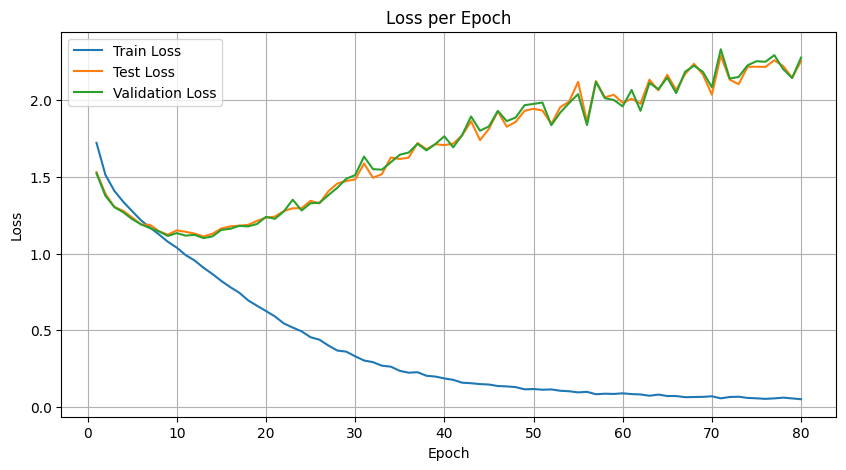

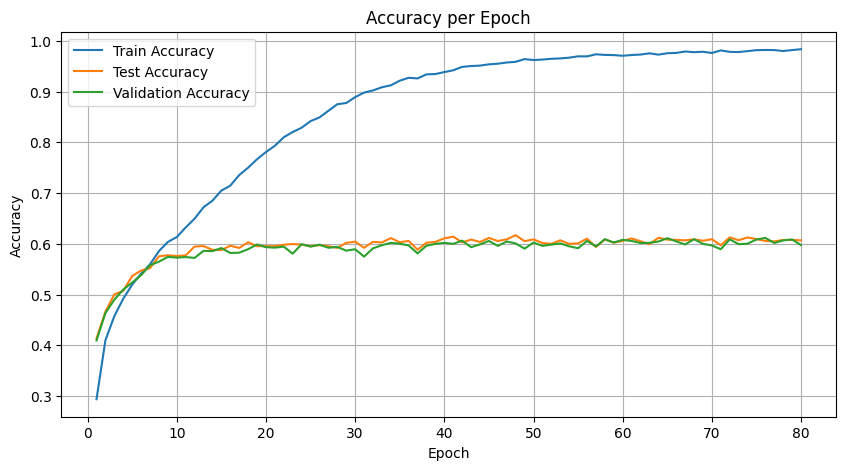

In [14]:
!pip install scikit-learn

Confusion Matrix:
 [[ 520   10   97   47  136  116   34]
 [  19   64    6    4    5   11    2]
 [ 146    3  449   51  109  171   89]
 [  74    4   54 1437  132   80   44]
 [ 120    6   75  114  688  187   26]
 [ 176    7  142   69  180  545   20]
 [  35    1   66   40   36   22  597]]


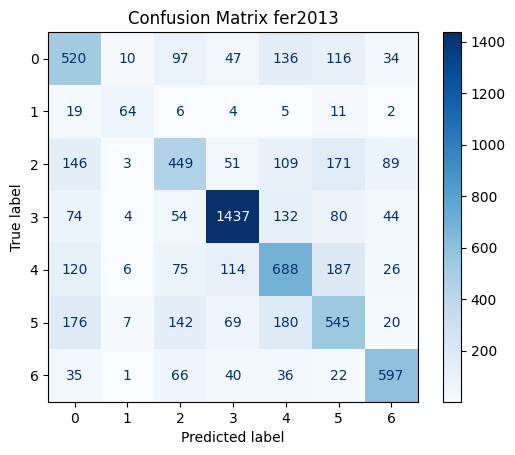

In [15]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Example: Dummy model outputs and labels
y_true = []  # Ground truth labels
y_pred = []  # Predicted labels

# Simulate predictions for test_loader
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        # Append predictions and true labels
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Convert to NumPy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Create confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix fer2013")
plt.show()


Confusion Matrix (Counts):
 [[ 522   13  102   49  132  112   30]
 [  17   63    8    4    5   10    4]
 [ 146    6  451   41  112  177   85]
 [  73    4   44 1460  115   82   47]
 [ 126    5   77  101  700  177   30]
 [ 182    9  146   63  196  528   15]
 [  32    1   67   39   33   23  602]]
Confusion Matrix (Percentages):
 [[0.54375    0.01354167 0.10625    0.05104167 0.1375     0.11666667
  0.03125   ]
 [0.15315315 0.56756757 0.07207207 0.03603604 0.04504505 0.09009009
  0.03603604]
 [0.14341847 0.00589391 0.44302554 0.04027505 0.11001965 0.17387033
  0.08349705]
 [0.04       0.00219178 0.02410959 0.8        0.0630137  0.04493151
  0.02575342]
 [0.10361842 0.00411184 0.06332237 0.08305921 0.57565789 0.14555921
  0.02467105]
 [0.15978929 0.00790167 0.12818262 0.05531168 0.17208077 0.46356453
  0.01316945]
 [0.04015056 0.00125471 0.08406524 0.0489335  0.04140527 0.02885822
  0.7553325 ]]


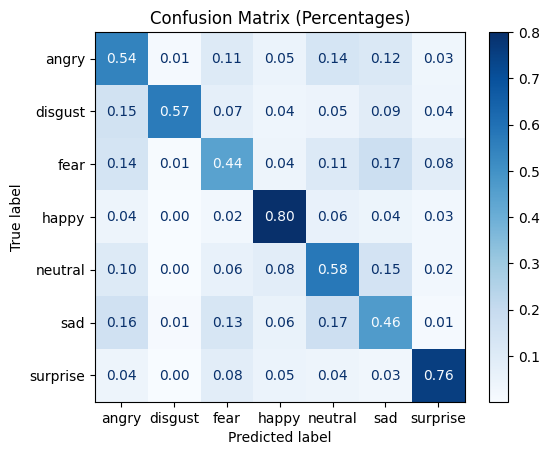

In [16]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Example: Dummy model outputs and labels
y_true = []  # Ground truth labels
y_pred = []  # Predicted labels

# Simulate predictions for test_loader
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        # Append predictions and true labels
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Convert to NumPy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Create confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix (Counts):\n", conf_matrix)

# Normalize confusion matrix by row (true classes) to get percentages
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1, keepdims=True)
print("Confusion Matrix (Percentages):\n", conf_matrix_normalized)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_normalized, display_labels=label_names)
disp.plot(cmap=plt.cm.Blues, values_format=".2f")  # Display percentages with 2 decimal places
plt.title("Confusion Matrix (Percentages)")
plt.show()
